# Applied Data Science Capstone from IBM
## Week3
### Segmenting and Clustering Neighborhoods in Toronto

Author: Carlos A. Evangelista Busso

## Part 1
For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

Start by creating a new Notebook for this assignment.
Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Import Libraries

In [1]:
pip install lxml

     |████████████████████████████████| 5.8MB 30.6MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import lxml.html as lh
import pandas as pd
import requests # library to handle requests
import numpy as np
import matplotlib.pyplot as plt
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # import k-means from clustering stage
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

The code below allows us to get the data of the HTML table.

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

For sanity check, ensure that all the rows have the same width. If not, we probably got something more than just the table.

In [4]:
#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

Looks like all our rows have exactly 3 columns. This means all the data collected on tr_elements are from the table.

### Parse Table Header
Next, let’s parse the first row as our header.

In [5]:
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print('%d:"%s"' %(i,name))
    col.append((name,[]))

1:"Postal code
"
2:"Borough
"
3:"Neighborhood
"


### Creating Pandas DataFrame
Each header is appended to a tuple along with an empty list.

In [6]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Just to be sure, let’s check the length of each column. Ideally, they should all be the same.

In [7]:
[len(C) for (title,C) in col]

[181, 181, 181]

Perfect! This shows that each of our 3 columns has exactly 181 values.

In [8]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

Looking at the top 5 cells on the DataFrame:

In [9]:
df.head()

,Postal code\n,Borough\n,Neighborhood\n
0,M1A\n,Not assigned\n,\n
1,M2A\n,Not assigned\n,\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,Regent Park / Harbourfront\n


Check the headers of each column

In [10]:
df.columns

Index(['Postal code\n', 'Borough\n', 'Neighborhood\n'], dtype='object')

Rename the headers

In [11]:
df.rename(columns={'Postal code\n':'PostalCode',
                   'Borough\n':'Borough',
                   'Neighborhood\n':'Neighborhood'},inplace=True)
df.columns

Index(['PostalCode', 'Borough', 'Neighborhood'], dtype='object')

It is right!!! Now we can proceed to the next step clean columns erasing the string '\n'

In [12]:
df['PostalCode'] = df['PostalCode'].map(lambda x: x.rstrip('\n'))
df['Borough'] = df['Borough'].map(lambda x: x.rstrip('\n'))
df['Neighborhood'] = df['Neighborhood'].map(lambda x: x.rstrip('\n'))

In [13]:
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


we drop the rows with 'Not assigned'

In [14]:
dataframe=df.drop(df[df.Borough == 'Not assigned'].index)
dataframe=dataframe.reset_index(drop=True)
dataframe.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


We check if there is any repeated value in the column: 'PostalCode'

In [15]:
len(dataframe.groupby('PostalCode').count())

104

In [16]:
dataframe.shape

(104, 3)

we replace the string: ' /' with ','

In [17]:
dataframe['Neighborhood']=dataframe['Neighborhood'].str.replace(' /',',')
dataframe.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


print column name with missing values

In [18]:
dataframe.columns[dataframe.isnull().any()]

Index([], dtype='object')

In [19]:
dataframe

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Business reply mail Processing CentrE
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."
102,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


Drop the last row

In [20]:
dataframe=dataframe.drop(dataframe[dataframe.Borough == 'Canadian postal codes'].index)
dataframe

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road , Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Business reply mail Processing CentrE
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Shape of dataframe

In [21]:
dataframe.shape

(103, 3)

## Part 2

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

Installed the necessary library

In [22]:
!conda install -c conda-forge geopy --yes

Solving environment: done

# All requested packages already installed.



Create dataframe for coodinates

In [23]:
coordi=pd.DataFrame(columns=["Latitude","Longitude"])
coordi

,Latitude,Longitude


Try to extract the coordinates for the neighborhoods

In [24]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="myGeocoder")

for i in range(len(dataframe)):
    location = locator.geocode("{},{}".format(dataframe.loc[i,"Borough"], str(dataframe.loc[i,"Neighborhood"]).split(',', 1)[0]))
    print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))


#cordi.append({"Latitude":1},ignore_index=True)

#col[i][1].append(data)

Latitude = 43.7587999, Longitude = -79.3201966
Latitude = 43.732658, Longitude = -79.3111892
Latitude = 43.66175185, Longitude = -79.35684015397013
Latitude = 43.7220788, Longitude = -79.4375067


AttributeError: 'NoneType' object has no attribute 'latitude'

### It is difficult to extract the coordinate data, therefore it is extracted from the .csv file

We will import the data from the csv file

In [ ]:
!wget -q -O 'Geospatial_Coordinates.csv' https://cocl.us/Geospatial_data
print('Data downloaded!')

In [33]:
df_coordinates = pd.read_csv('Geospatial_Coordinates.csv')
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [34]:
df_coordinates.rename(columns={'Postal Code':'PostalCode'},inplace=True)
df_coordinates.columns

Index(['PostalCode', 'Latitude', 'Longitude'], dtype='object')

In [35]:
dataframe.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Join the dataframes using the merge method

In [36]:
df_total=dataframe.merge(df_coordinates, on='PostalCode')
df_total

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road , Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


Check the shape from the dataframe

In [37]:
df_total.shape

(103, 5)

### We will only work with the neighborhoods of Toronto

In [38]:
df_total=df_total[df_total['Borough'].str.contains('Toronto')]
df_total=df_total.reset_index(drop=True)
df_total.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


## Part 3

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

* to add enough Markdown cells to explain what you decided to do and to report any observations you make.
* to generate maps to visualize your neighborhoods and how they cluster together.

## 1. Download and Explore Dataset

Installed the necessary library

In [39]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    pandas-1.0.3               |   py36h830a2c2_1        11.1 MB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-

#### Use geopy library to get the latitude and longitude values of Toronto.

In [40]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [41]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_total['Latitude'], df_total['Longitude'], df_total['Borough'], df_total['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [43]:
neighborhood_latitude = df_total.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_total.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = str(df_total.loc[0,"Neighborhood"]).split(',', 1)[0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park are 43.6542599, -79.3606359.


In [44]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=X0PWS3LNMMHKQR5RZTJLF31TLXP0VYMODMO1KH3XI5LRB30A&client_secret=5LXZUTRNT1FVESLON4PCJMKTODAYTVY2CKNG5PNT0G5NY4L0&v=20180605&ll=43.6542599,-79.3606359&radius=500&limit=100'

We make the call to the API

In [45]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ea84480c94979001bf4bc4e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 48,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

In [46]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [47]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
3,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
4,Body Blitz Spa East,Spa,43.654735,-79.359874


## 2. Explore Neighborhoods in Manhattan
#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
df_Neighborhood = df_total["Neighborhood"].map(lambda x: x.split(',', 1)[0])

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [50]:
# type your answer here
toronto_venues = getNearbyVenues(names=df_Neighborhood,
                                   latitudes=df_total['Latitude'],
                                   longitudes=df_total['Longitude']
                                  )


Regent Park
Queen's Park
Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond
Dufferin
Harbourfront East
Little Portugal
The Danforth West
Toronto Dominion Centre
Brockton
India Bazaar
Commerce Court
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park
North Toronto West
The Annex
Parkdale
Davisville
University of Toronto
Runnymede
Moore Park
Kensington Market
Summerhill West
CN Tower
Rosedale
Stn A PO Boxes
St. James Town
First Canadian Place
Church and Wellesley
Business reply mail Processing CentrE


#### Let's check the size of the resulting dataframe

In [51]:
print(toronto_venues.shape)
toronto_venues.head()

(1623, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Regent Park,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Regent Park,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Regent Park,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,Regent Park,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,Regent Park,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Let's check how many venues were returned for each neighborhood

In [52]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
Brockton,24,24,24,24,24,24
Business reply mail Processing CentrE,17,17,17,17,17,17
CN Tower,16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,17,17,17,17,17,17
Church and Wellesley,75,75,75,75,75,75
Commerce Court,100,100,100,100,100,100
Davisville,35,35,35,35,35,35


#### Let's find out how many unique categories can be curated from all the returned venues

In [53]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 226 uniques categories.


## 3. Analyze Each Neighborhood

In [54]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood Name'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood Name,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Regent Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Regent Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Regent Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Regent Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Regent Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
toronto_onehot.shape

(1623, 227)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [56]:
toronto_grouped = toronto_onehot.groupby('Neighborhood Name').mean().reset_index()
toronto_grouped.head()

,Neighborhood Name,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.000000
1,Brockton,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,Business reply mail Processing CentrE,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.058824
3,CN Tower,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,Central Bay Street,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.015625


#### Let's confirm the new size

In [57]:
toronto_grouped.shape

(38, 227)

#### Let's print each neighborhood along with the top 5 most common venues

In [58]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood Name']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2  Italian Restaurant  0.03
3          Restaurant  0.03
4         Cheese Shop  0.03


----Brockton----
                   venue  freq
0                   Café  0.12
1            Coffee Shop  0.08
2         Breakfast Spot  0.08
3              Nightclub  0.08
4  Performing Arts Venue  0.04


----Business reply mail Processing CentrE----
                venue  freq
0  Light Rail Station  0.12
1         Yoga Studio  0.06
2       Garden Center  0.06
3                Park  0.06
4          Comic Shop  0.06


----CN Tower----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3           Airport  0.06
4               Bar  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.20
1  Italian Restaurant  0.08
2                Café  0.06
3      Sandwich Place  0.05
4        Burger Joint  0.03


----Christie----


#### Let's put that into a *pandas* dataframe
First, let's write a function to sort the venues in descending order.

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood Name'] = toronto_grouped['Neighborhood Name']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head()
print(toronto_venues_sorted.shape)


(38, 11)


## 4. Cluster Neighborhoods
Run *k*-means to cluster the neighborhood into 5 clusters.

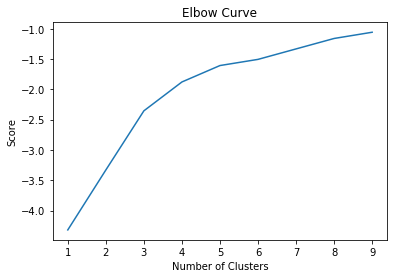

In [61]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood Name', 1)

Nc = range(1, 10)

kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(toronto_grouped_clustering).score(toronto_grouped_clustering) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


Kmeans for 3 clusters

In [62]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Insert labels of Kmeans

In [63]:
# add clustering labels
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_venues_sorted.head()

,Cluster Labels,Neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Berczy Park,Coffee Shop,Cocktail Bar,Café,Cheese Shop,Seafood Restaurant,Bakery,Restaurant,Italian Restaurant,Beer Bar,Farmers Market
1,0,Brockton,Café,Nightclub,Breakfast Spot,Coffee Shop,Music Venue,Pet Store,Burrito Place,Restaurant,Italian Restaurant,Intersection
2,0,Business reply mail Processing CentrE,Light Rail Station,Yoga Studio,Auto Workshop,Comic Shop,Park,Pizza Place,Burrito Place,Restaurant,Brewery,Smoke Shop
3,0,CN Tower,Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina,Boutique,Boat or Ferry,Bar,Coffee Shop,Sculpture Garden
4,0,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Ice Cream Shop,Fried Chicken Joint,Salad Place,Bubble Tea Shop,Burger Joint,Yoga Studio


In [64]:
df_total=df_total.rename(columns={"Neighborhood": "Neighborhood Name"})
df_total.head()

,PostalCode,Borough,Neighborhood Name,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [65]:
df_total['Neighborhood Name']=df_total['Neighborhood Name'].map(lambda x: x.split(',', 1)[0])
df_total.head()

,PostalCode,Borough,Neighborhood Name,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Join two dattaframes en df_final

In [66]:
df_final=df_total.merge(toronto_venues_sorted, on='Neighborhood Name')
df_final.head(10)

,PostalCode,Borough,Neighborhood Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636,0,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Restaurant,Hotel,Ice Cream Shop
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Diner,Beer Bar,Hobby Shop,Bank,Bar,Spa,Café,Yoga Studio
2,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,0,Clothing Store,Coffee Shop,Café,Middle Eastern Restaurant,Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Diner,Theater
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Italian Restaurant,Restaurant,Gastropub,American Restaurant,Bakery,Cocktail Bar,Clothing Store,Lingerie Store
4,M4X,Downtown Toronto,St. James Town,43.667967,-79.367675,0,Coffee Shop,Café,Italian Restaurant,Restaurant,Gastropub,American Restaurant,Bakery,Cocktail Bar,Clothing Store,Lingerie Store
5,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Neighborhood,Park,Doner Restaurant,Dog Run,Distribution Center,Cuban Restaurant,Discount Store
6,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Café,Cheese Shop,Seafood Restaurant,Bakery,Restaurant,Italian Restaurant,Beer Bar,Farmers Market
7,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Ice Cream Shop,Fried Chicken Joint,Salad Place,Bubble Tea Shop,Burger Joint,Yoga Studio
8,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,Grocery Store,Café,Park,Baby Store,Diner,Nightclub,Candy Store,Gas Station,Coffee Shop,Restaurant
9,M5H,Downtown Toronto,Richmond,43.650571,-79.384568,0,Coffee Shop,Café,Restaurant,Deli / Bodega,Clothing Store,American Restaurant,Gym,Thai Restaurant,Hotel,Sushi Restaurant


In [67]:
df_final.shape

(39, 16)

Finally, let's visualize the resulting clusters

In [68]:
# create map
map_clusters_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood Name'], df_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_toronto)
       
map_clusters_toronto

In [69]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [71]:
df_final.loc[df_final['Cluster Labels'] == 0, df_final.columns[[1] + list(range(5, df_final.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Pub,Bakery,Park,Café,Breakfast Spot,Theater,Restaurant,Hotel,Ice Cream Shop
1,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Diner,Beer Bar,Hobby Shop,Bank,Bar,Spa,Café,Yoga Studio
2,Downtown Toronto,0,Clothing Store,Coffee Shop,Café,Middle Eastern Restaurant,Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Diner,Theater
3,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Restaurant,Gastropub,American Restaurant,Bakery,Cocktail Bar,Clothing Store,Lingerie Store
4,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Restaurant,Gastropub,American Restaurant,Bakery,Cocktail Bar,Clothing Store,Lingerie Store
5,East Toronto,0,Pub,Trail,Health Food Store,Neighborhood,Park,Doner Restaurant,Dog Run,Distribution Center,Cuban Restaurant,Discount Store
6,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Café,Cheese Shop,Seafood Restaurant,Bakery,Restaurant,Italian Restaurant,Beer Bar,Farmers Market
7,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Ice Cream Shop,Fried Chicken Joint,Salad Place,Bubble Tea Shop,Burger Joint,Yoga Studio
8,Downtown Toronto,0,Grocery Store,Café,Park,Baby Store,Diner,Nightclub,Candy Store,Gas Station,Coffee Shop,Restaurant
9,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Deli / Bodega,Clothing Store,American Restaurant,Gym,Thai Restaurant,Hotel,Sushi Restaurant


## -In the generated groups it can be observed that the most common places are Coffee Shop and  Italian restaurant

#### Cluster 2

In [72]:
df_final.loc[df_final['Cluster Labels'] == 1, df_final.columns[[1] + list(range(5, df_final.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Central Toronto,1,Playground,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


#### Cluster 3

In [73]:
df_final.loc[df_final['Cluster Labels'] == 2, df_final.columns[[1] + list(range(5, df_final.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Central Toronto,2,Garden,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


## -The rest of the groups do not contain any of the common places of the previous ones. This is the reason for grouping 37 neighborhoods into one group.